<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Assignment_05/Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & Standard Setup

In [2]:
!pip install jupyterthemes

    100% |████████████████████████████████| 7.0MB 4.3MB/s 
    100% |████████████████████████████████| 9.0MB 3.6MB/s 
    100% |████████████████████████████████| 51kB 20.9MB/s 
    100% |████████████████████████████████| 1.0MB 9.7MB/s 
    100% |████████████████████████████████| 51kB 19.5MB/s 
  Running setup.py bdist_wheel for prometheus-client ... - \ done
  Stored in directory: /root/.cache/pip/wheels/b9/96/bc/e2acadc6bbfe57a1f631a34ca4ce6dd057af059b8d6878202b
Successfully built prometheus-client
google-colab 0.0.1a1 has requirement notebook~=5.2.0, but you'll have notebook 5.7.0 which is incompatible.
  Found existing installation: pyzmq 16.0.4
    Uninstalling pyzmq-16.0.4:
      Successfully uninstalled pyzmq-16.0.4
  Found existing installation: notebook 5.2.2
    Uninstalling notebook-5.2.2:
      Successfully uninstalled notebook-5.2.2


In [0]:
%matplotlib inline

import os

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt  # for root mean-squared error calculation

# jt themes
from jupyterthemes import jtplot

# IPython display
from IPython.display import display

from scipy.io import loadmat # for loading .MAT files
import urllib.request

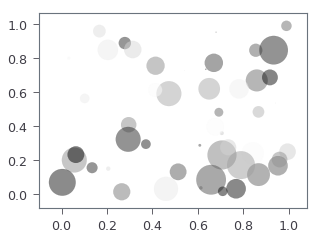

In [4]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

In [0]:
# santatize Dataset
def santatize_set( dataframe ):
    if dataframe.isnull().values.any() == True:
        cleaned = dataframe.dropna()
        print('Dropped {} invalid samples'.format(dataframe.count - cleaned.count))
        dataframe = cleaned
    return dataframe

In [0]:
# saves a plot for reporting later. 
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Utility

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# Dataset

This 'homebrew' method is the only way I could reliably get MNIST data. The 'fetch_mldata' literally works 1 / 50 tries.

In [0]:
from six.moves import urllib

from scipy.io import loadmat
mnist_alternative_url = "https://raw.githubusercontent.com/bmoretz/MSDS-MachineLearning/master/datasets/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}

In [0]:
X, y = mnist['data'], mnist['target']

In [63]:
X.shape

(70000, 784)

In [64]:
y.shape

(70000,)

# Exploration

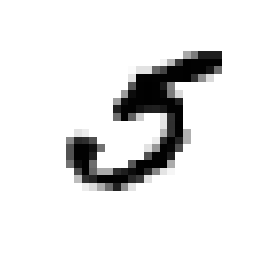

In [67]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

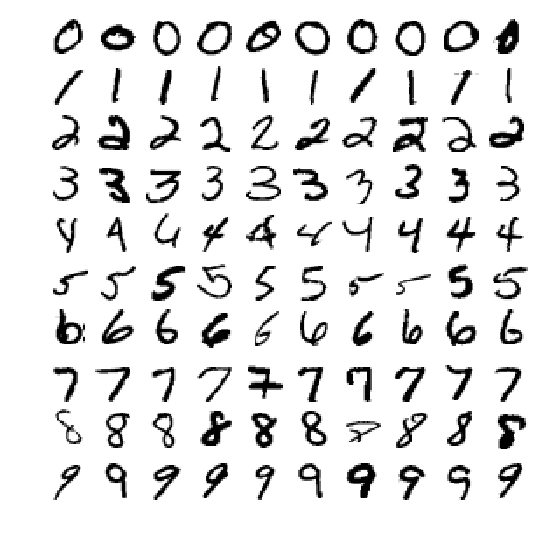

In [71]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [72]:
y[36000]

5.0

# Summary

In [0]:
perf_summary.set_index("Regressor", drop=True, inplace=True)

In [0]:
perf_summary.sort_values(by=['RMSE'])

,Score,MSE,RMSE
Regressor,,,
Decision Tree,69.1402,8.31506,0.196269
Random Forest,58.493,7.64807,0.320039
Linear,17.4389,4.17599,0.519423
Lasso,17.4283,4.17472,0.519715
Ridge,17.4086,4.17236,0.520258
Elastic Net,16.9186,4.11322,0.533761


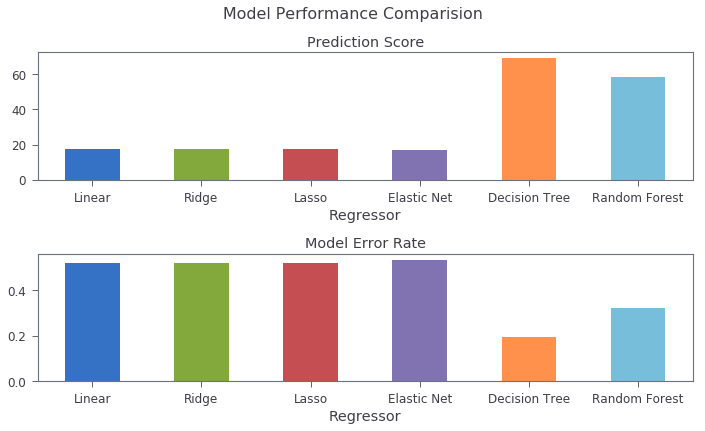

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Model Performance Comparision', y = 1.025)
fig.subplots_adjust(top=4)

plt.subplot(311)
perf_summary['Score'].plot(kind='bar', title ="Prediction Score", figsize=(10, 8), fontsize=12)
plt.xticks(rotation='horizontal')

plt.subplot(312)
perf_summary['RMSE'].plot(kind='bar', title ="Model Error Rate", figsize=(10, 8), fontsize=12)
plt.xticks(rotation='horizontal')

fig.tight_layout()
plt.show()

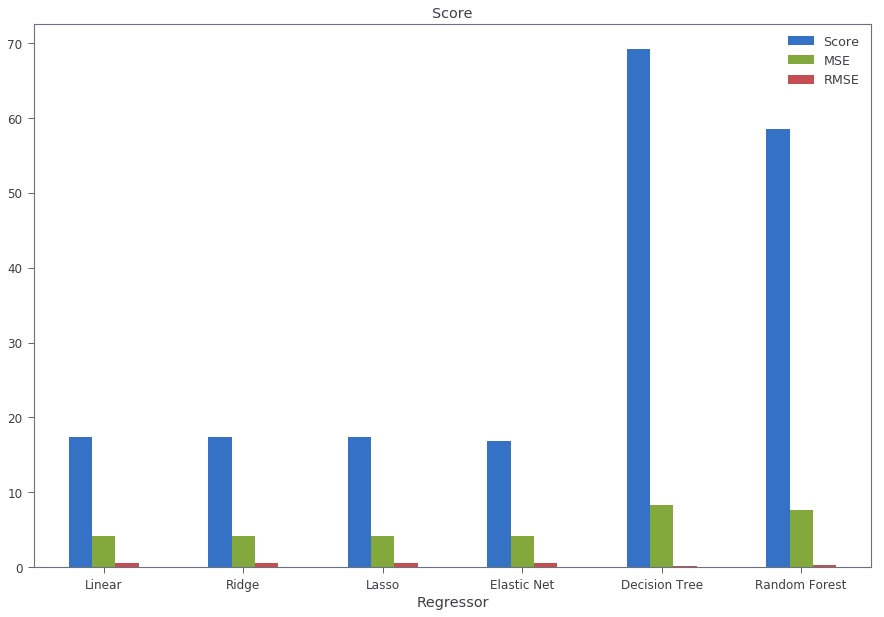

In [0]:
perf_summary.plot(kind='bar', title ="Score", figsize=(15, 10), fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()